In [5]:
import pandas as pd
import regex as re

In [1]:
import os, json
import math

def replace_nan_with_string(data):
    if isinstance(data, list):
        return [replace_nan_with_string(item) for item in data]
    elif isinstance(data, dict):
        return {key: replace_nan_with_string(value) for key, value in data.items()}
    elif isinstance(data, float) and math.isnan(data):
        return "Not Provided"
    else:
        return data

directory = "/Users/emilyzou/Desktop/pol/pol2"
merged_data = []

for file in os.listdir(directory):
    if file.endswith(".json"):
        with open(os.path.join(directory, file)) as f:
            data = json.load(f)
            data = replace_nan_with_string(data)  # Replace NaN values
            if isinstance(data, list):
                merged_data.extend(data)
            else:
                merged_data.append(data)

with open("11_19merged.json", "w") as f:
    json.dump(merged_data, f)


In [49]:
deimentions = pd.read_csv("/Users/emilyzou/Desktop/pol/deimentionposts.csv")

In [2]:
with open ('/Users/emilyzou/Desktop/pol/11_19merged.json') as file: 
    data = json.load(file)

In [8]:
len(data)

42486

In [16]:
def extract_dei_context(json_tree):
    return pd.DataFrame([
        {
            'Poster_Id': item['Poster_Id'],
            'ID': item['ID'],
            'Date': item['Date'],
            'Before_Word': match.group(1) if match.group(1) else 'None',
            'After_Word': match.group(2) if match.group(2) else 'None'
        }
        for item in json_tree
        for match in re.finditer(r'(\b\w+\b)?\s*dei\s*(\b\w+\b)?', item.get('Text', ''), re.IGNORECASE)
    ])

In [17]:
eg = extract_dei_context(data)

In [18]:
eg

,Poster_Id,ID,Date,Before_Word,After_Word
0,hiVvu0B9,471923648,2024-06-22 20:23:50,of,is
1,hiVvu0B9,471923648,2024-06-22 20:23:50,the,and
2,c9WClCF3,471921780,2024-06-22 19:58:36,None,is
3,Not Provided,471920295,2024-06-22 19:36:18,a,handout
4,dk22vhv0,471918860,2024-06-22 19:15:49,want,for
...,...,...,...,...,...
43224,Not Provided,482494153,2024-09-22 06:12:16,of,payoff
43225,Not Provided,482883002,2024-09-26 03:39:10,word,tranny
43226,Not Provided,483146546,2024-09-28 14:58:04,None,is
43227,Not Provided,483780654,2024-10-04 10:44:42,or,detected


In [20]:
from collections import Counter

In [24]:
from lingua import Language, LanguageDetectorBuilder

# Language detector setup
languages = [Language.LATIN, Language.ENGLISH, Language.ITALIAN]
detector = LanguageDetectorBuilder.from_languages(*languages).build()

def latin_italian_exterminator(s):
    latin_confidence_value = detector.compute_language_confidence(s, Language.LATIN)
    latin_cv = float(f"{latin_confidence_value:.2f}") 
    italian_confidence_value = detector.compute_language_confidence(s, Language.ITALIAN)
    italian_cv = float(f"{italian_confidence_value:.2f}")
    return (latin_cv, italian_cv)

def is_latin_or_italian(word):
    if latin_italian_exterminator(word)[0] > 0.55:
        return False
    elif latin_italian_exterminator(word)[1] >0.55: 
        return False
    else: 
        return True

In [ ]:
eg['Before_English'] = eg['Before_Word'].apply(is_latin_or_italian)
eg['After_English'] = eg['After_Word'].apply(is_latin_or_italian)

In [ ]:
fdf = eg[(eg['Before_English']) & (eg['After_English'])]
engids = [m for m in fdf['ID']]

In [38]:
fdf['Trigram'] = fdf['Before_Word'] + ' dei ' + fdf['After_Word']
trigram_counts = fdf.groupby('Trigram').size().reset_index(name='Count')
trigram_counts_sorted = trigram_counts.sort_values(by='Count', ascending=False)

/var/folders/b9/j4cr1qk10pgfhhshk13f4zgm0000gn/T/ipykernel_45568/1011210863.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf['Trigram'] = fdf['Before_Word'] + ' dei ' + fdf['After_Word']


In [70]:
fdf.to_csv("11_20trigrammed.csv")

In [ ]:
trigram_counts_sorted.head(30)

In [43]:
deihiredf = fdf[fdf['Trigram'] == "a dei hire"]

In [56]:
deihireids = [int(m) for m in deihiredf['ID']]

In [51]:
deimentions = pd.read_csv("/Users/emilyzou/Desktop/pol/deimentionposts.csv")

In [57]:
hiresents = deimentions[deimentions['Thread No'].isin(deihireids)]

In [46]:
deishitdf = fdf[fdf['Trigram'] =="the dei shit"]

In [60]:
deishitids = [int(m) for m in deishitdf['ID']]
shitsents = deimentions[deimentions['Thread No'].isin(deishitids)]

In [61]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

def get_phrase_embeddings(df, model_name="bert-base-uncased"):
    # Load pre-trained BERT model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()

    embeddings = []

    # Compute embeddings for each sentence
    for sentence in df['Text']:
        # Tokenize and get input tensors
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)

        # Use the CLS token embedding as the sentence embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)

    return np.array(embeddings)

# Assume df_hire and df_shit are your DataFrames
embeddings_hire = get_phrase_embeddings(hiresents)
embeddings_shit = get_phrase_embeddings(shitsents)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


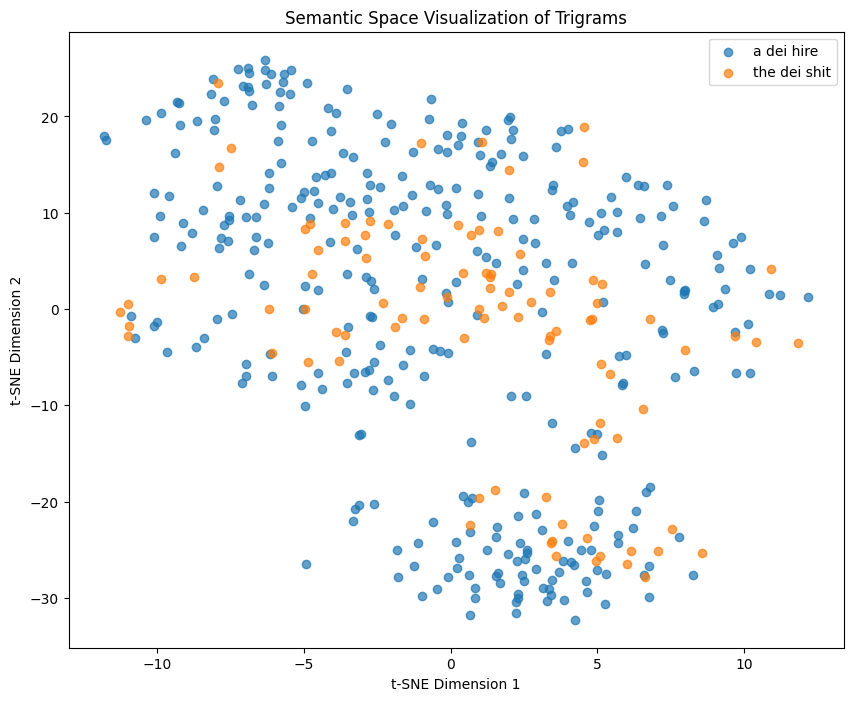

In [62]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine embeddings and labels
embeddings = np.vstack([embeddings_hire, embeddings_shit])
labels = ['a dei hire'] * len(embeddings_hire) + ['the dei shit'] * len(embeddings_shit)

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the 2D projection
plt.figure(figsize=(10, 8))
for label, color in zip(['a dei hire', 'the dei shit'], ['blue', 'red']):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=label, alpha=0.7)

plt.legend()
plt.title("Semantic Space Visualization of Trigrams")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create labels (0 for 'a dei hire', 1 for 'the dei shit')
labels_numeric = [0] * len(embeddings_hire) + [1] * len(embeddings_shit)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels_numeric, test_size=0.2, random_state=42)

# Train logistic regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.93      0.93        68
           1       0.72      0.72      0.72        18

    accuracy                           0.88        86
   macro avg       0.82      0.82      0.82        86
weighted avg       0.88      0.88      0.88        86



In [67]:
from sklearn.cluster import KMeans
from collections import Counter

# Perform K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Analyze clustering results
cluster_labels = ['Cluster 1', 'Cluster 2']
cluster_counts = Counter(clusters)

print("Cluster counts:", cluster_counts)

# Map clusters to original labels for analysis
cluster_mapping = {0: 'a dei hire', 1: 'the dei shit'}
df_clusters = pd.DataFrame({
    'Sentence': list(hiresents['Text']) + list(shitsents['Text']),
    'Trigram': labels,
    'Cluster': [cluster_mapping[cluster] for cluster in clusters]
})

print(df_clusters.head())


/Users/emilyzou/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster counts: Counter({1: 318, 0: 112})
                                            Sentence     Trigram       Cluster
0  he's a mi6 puke using a cia provided proxy for...  a dei hire    a dei hire
1  all the traders know everything is fake - ever...  a dei hire  the dei shit
2  So going by the video and other evidence, she ...  a dei hire    a dei hire
3  Do you think a DEI hire would understand SOX a...  a dei hire  the dei shit
4  most corpo jobs DEI and them not being willing...  a dei hire  the dei shit


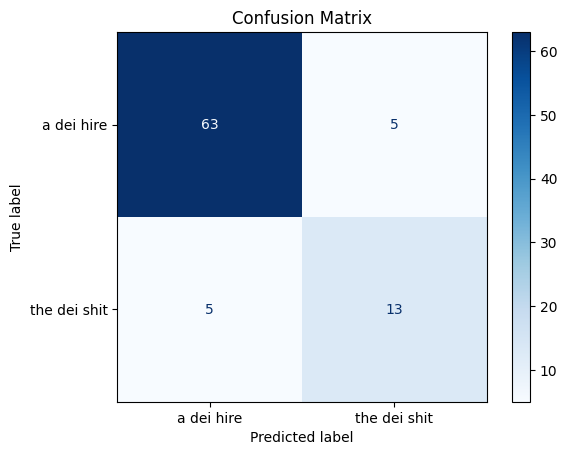

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['a dei hire', 'the dei shit'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


IndexError: list index out of range

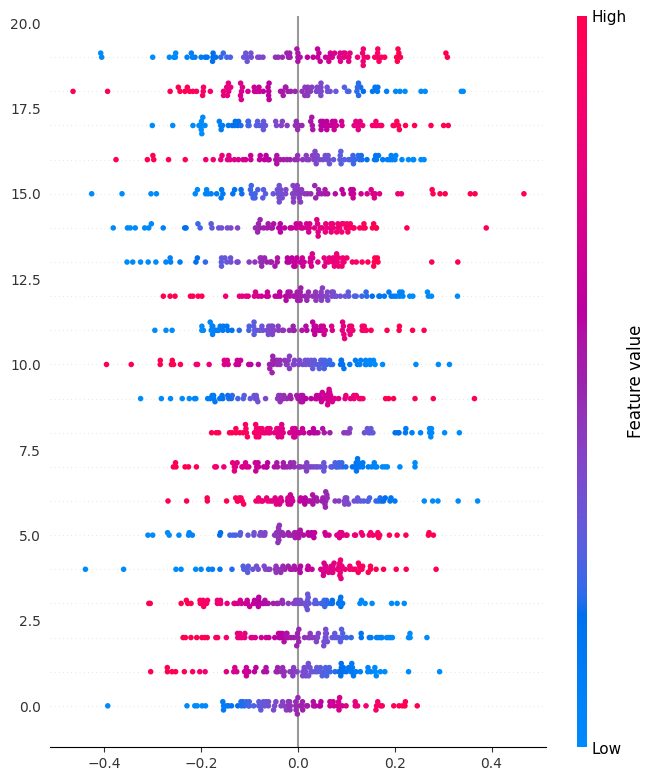

In [74]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test)

# Plot summary of SHAP values
shap.summary_plot(shap_values, feature_names=['Embedding Dimensions'])



In [75]:
c9 = [m for m in data if m['ID'] in engids]
len(c9)

38261

In [35]:
with open("11_20merged.json", "w") as f:
    json.dump(c9, f)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt